**Введение**
  
  CNN для классификации  присутствия святого Георгия на изображении.

*Этапы разработки:*

    
     
     
     
     
     
     
     



1.    Загрузить и подготовить изображения для учебных целей.
2.   Разделить данные для целей обучения и проверки.
3.   Применить увеличение данных к данным.
4.   Разработать модель CNN с использованием keras и как выбрать различные параметры для повышения производительности модели.
5.   Оценить производительность модели.
6.   Сохранить и загрузить модель для дальнейших прогнозов.



На обучение, мне потребовалось некоторое время, чтобы обучить модель (4 часа процессорах).
Так что просто напишем код для обучения и после этого загрузим обученную модель.




     
     
     



**Загрузка библиотек**

In [9]:
import os
import gdown
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

#keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



**Извлечение обучающих данных**

In [ ]:
url = 'https://drive.google.com/file/d/1Z02YIQLQpne32qLTKnM501GWRzq0dOxW/view?usp=drive_link'
output_path = 'george_test_task.tar.xz'
gdown.download(url, output_path, quiet=False,fuzzy=True)
%mkdir temporary
!tar -xvf  george_test_task.tar.xz

**Предварительная обработка и увеличение данных**

Чтобы максимально эффективно использовать наши несколько обучающих примеров, мы «дополним» их с помощью ряда случайных преобразований, чтобы наша модель никогда не видела дважды одну и ту же картину. Это помогает предотвратить переоснащение и помогает модели лучше обобщать

In [6]:
#from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

add_augementations = 0

image_dir = "george_test_task/george/"
filenames_george = os.listdir(image_dir)

image_dir = "george_test_task/no_george/"
filenames_no_george = os.listdir(image_dir)

if len(filenames_no_george)>len(filenames_george):
  add_augementations=len(filenames_no_george)-len(filenames_george)
elif  len(filenames_no_george)<len(filenames_george):
  add_augementations=len(filenames_george)-len(filenames_no_george)

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


for img in filenames_george:
  image_dir = "temporary/"
  filenames_george = os.listdir(image_dir)
  if add_augementations==len(filenames_george):
    break
  img = load_img(f'george_test_task/george/{img}')
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape)
  datagen.flow(x, batch_size=1,save_to_dir='temporary', save_prefix='george', save_format='jpg').next()

%cp temporary/* george_test_task/george/
%mkdir mydataset
%cp george_test_task/george/* mydataset
%cp george_test_task/no_george/* mydataset

**Визуализация дополненных данных**



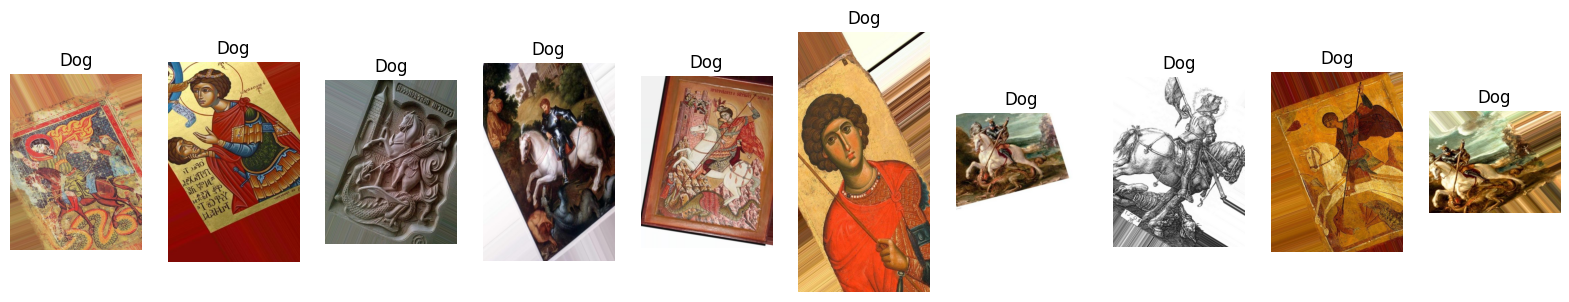

In [8]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)
j=0

for i in filenames_george[:10]:
    j+=1
    plt.subplot(1,10,j)
    filename = 'temporary/' + str(i)
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

 **Загрузка изображений в Dataframe**

In [ ]:

image_dir = "george_test_task/george/"
filenames_george = os.listdir(image_dir)
labels_george = len(filenames_george)*['1']


image_dir = "george_test_task/no_george/"
filenames_no_george = os.listdir(image_dir)
labels_no_george = len(filenames_no_george)*['0']

filenames=filenames_george + filenames_no_george
labels = labels_george + labels_no_george


data = pd.DataFrame({"filename": filenames, "label": labels})
data.head()



Теперь мы создадим гистограмму, чтобы увидеть распределение классов в наборе обучающих данных.

In [13]:
# train test split using dataframe

labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (5387, 2)
The shape of test data (673, 2)
The shape of validation data (674, 2)


<ipython-input-14-29a3176dd136>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
<ipython-input-14-29a3176dd136>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in validation set',fontsize=15)
<ipython-input-14-29a3176dd136>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',w

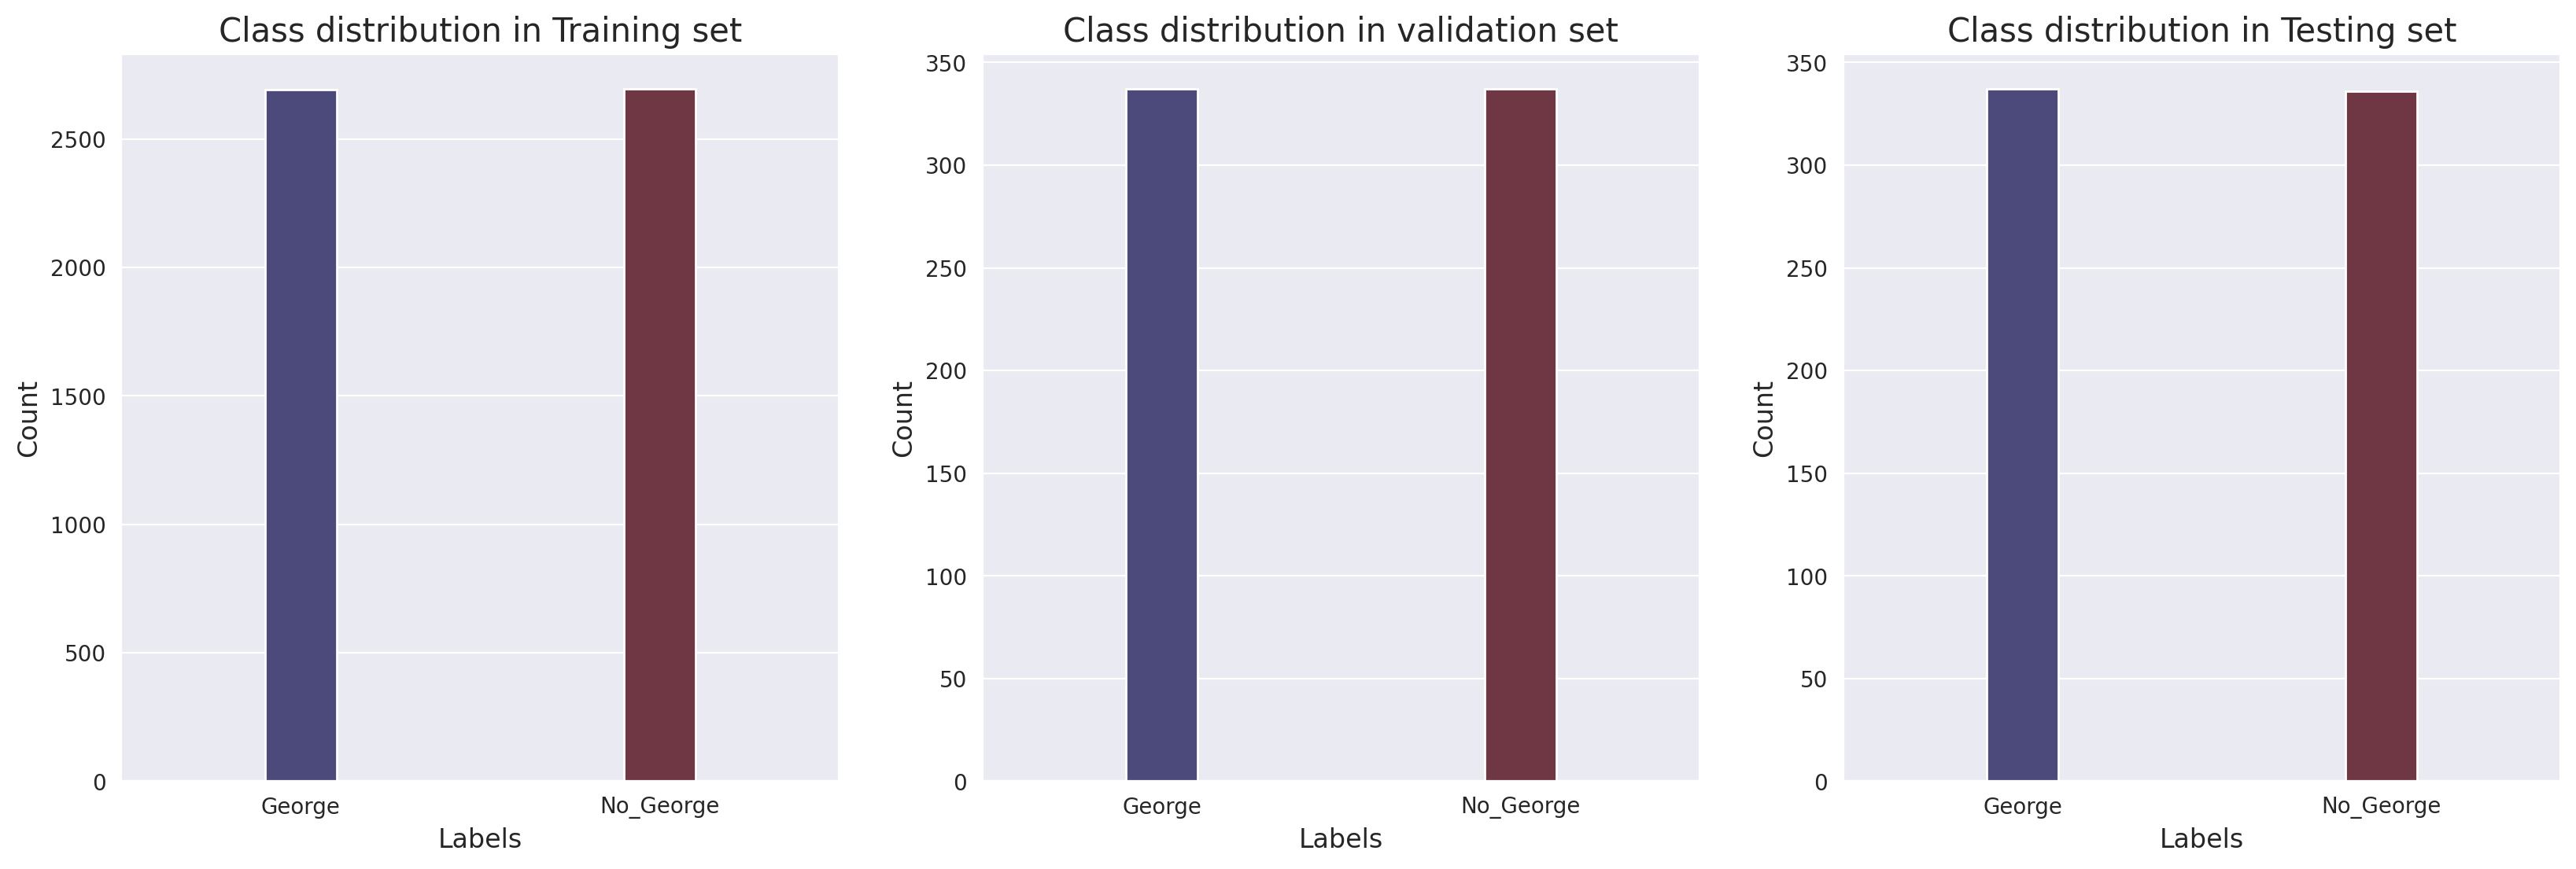

In [14]:
labels = ['George','No_George']

label1,count1 = np.unique(X_train.label,return_counts=True)
label2,count2 = np.unique(X_val.label,return_counts=True)
label3,count3 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

**Подготовка данных**



Перечислим все важные параметры и соответствующие значения.

In [6]:
image_size = 256
image_channel = 3
bat_size = 32

In [15]:
%rm dataset/*
# create directories
dataset_home = 'dataset/'
subdirs = ['train/', 'test/']

for subdir in subdirs:
    labeldirs = ['george/', 'no_george/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
seed(1)
val_ratio = 0.2
src_directory = 'george_test_task/george/'
for file in listdir(src_directory):
        src = src_directory + '/' + file
        dst_dir = 'train/'
        if random() < val_ratio:
            dst_dir = 'test/'
        dst = dataset_home + dst_dir + 'george/' + file
        copyfile(src, dst)


src_directory = 'george_test_task/no_george/'
for file in listdir(src_directory):
        src = src_directory + '/' + file
        dst_dir = 'train/'
        if random() < val_ratio:
            dst_dir = 'test/'
        dst = dataset_home + dst_dir + 'no_george/' + file
        copyfile(src, dst)


path1 = "dataset/train/george"
path2 = "dataset/train/no_george"
path3 = "dataset/test/george"
path4 = "dataset/test/no_george"


print('Then number of cat images in training data is' ,len(os.listdir(path1)))
print('Then number of dog images in training data is' ,len(os.listdir(path2)))
print('Then number of cat images in validation data is' ,len(os.listdir(path3)))
print('Then number of dog images in validation data is' ,len(os.listdir(path4)))


rm: cannot remove 'dataset/*': No such file or directory
Then number of cat images in training data is 2698
Then number of dog images in training data is 2688
Then number of cat images in validation data is 669
Then number of dog images in validation data is 679


**Генератор данных изображения**


*   Данные будут использоваться flow_from_dataframe и flow_from_directory.


*   Размер пакета — 32, а размер изображения — (256 256).



In [19]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 0,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)




train_generator = train_datagen.flow_from_dataframe(dataframe=X_train,
                                                    directory = 'mydataset/',
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                 directory = 'mydataset/',
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                  directory = 'mydataset/',
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )


train_gen = train_datagen.flow_from_directory('dataset/train/',
                                              class_mode='binary',
                                              target_size = (image_size,image_size),
                                              batch_size = bat_size,
                                             )

val_gen = test_datagen.flow_from_directory('dataset/test/',
                                          class_mode='binary',
                                          batch_size = bat_size,
                                          target_size = (image_size,image_size),
                                          shuffle = False
                                         )





Found 5118 validated image filenames belonging to 2 classes.
Found 634 validated image filenames belonging to 2 classes.
Found 633 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 269 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 40 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 40 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


**Модель глубокого обучения**

Архитектура модели классификации присутствия святого Георгия на изображении состоит из следующих слоев и компонентов:
Слои:

    Входной слой состоит из Conv2D с 32 фильтрами и функцией активации.
    Модель содержит 3 блока свертки с повышающими фильтрами и активацией релу.
    Каждый блок свертки содержит пакетную нормализацию, максимальное объединение в пул (pool_size = 2) и исключение (0,2).
    Полностью связанные слои содержат слой Flatten, слой Dense с 512 единицами и слой Dropout.
    Выходной слой представляет собой плотный слой с 2 ​​единицами и активацией softmax.



In [7]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Bloack 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)     

**Обратные вызовы**

     ReduceLROnPlateau: снизить скорость обучения, когда метрика перестает улучшаться.
     EarlyStopping: прекратите обучение, когда отслеживаемый показатель перестанет улучшаться.

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)


**Скомпилируем модель**

     Optimizer: — Чтобы минимизировать функцию потерь. Используем здесь значение по умолчанию — Адам.  
     Loss: — Чтобы сделать нашу модель лучше, мы либо минимизируем потери, либо максимизируем точность.  Нейронные сети всегда минимизируют потери.   Здесь я используем binary_crossentropy.  
     Metrics: – это обозначение меры вашей модели.  

In [23]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

**Обучение модели**

Обучение  скомпилированную модель с помощью итератора train_generator и использовать итератор val_generator в качестве набора данных проверки во время обучения.


In [ ]:
cat_dog = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks=[early_stoping,learning_rate_reduction],
                    epochs = 30
                   )



**Графики точности и потерь с эпохами**




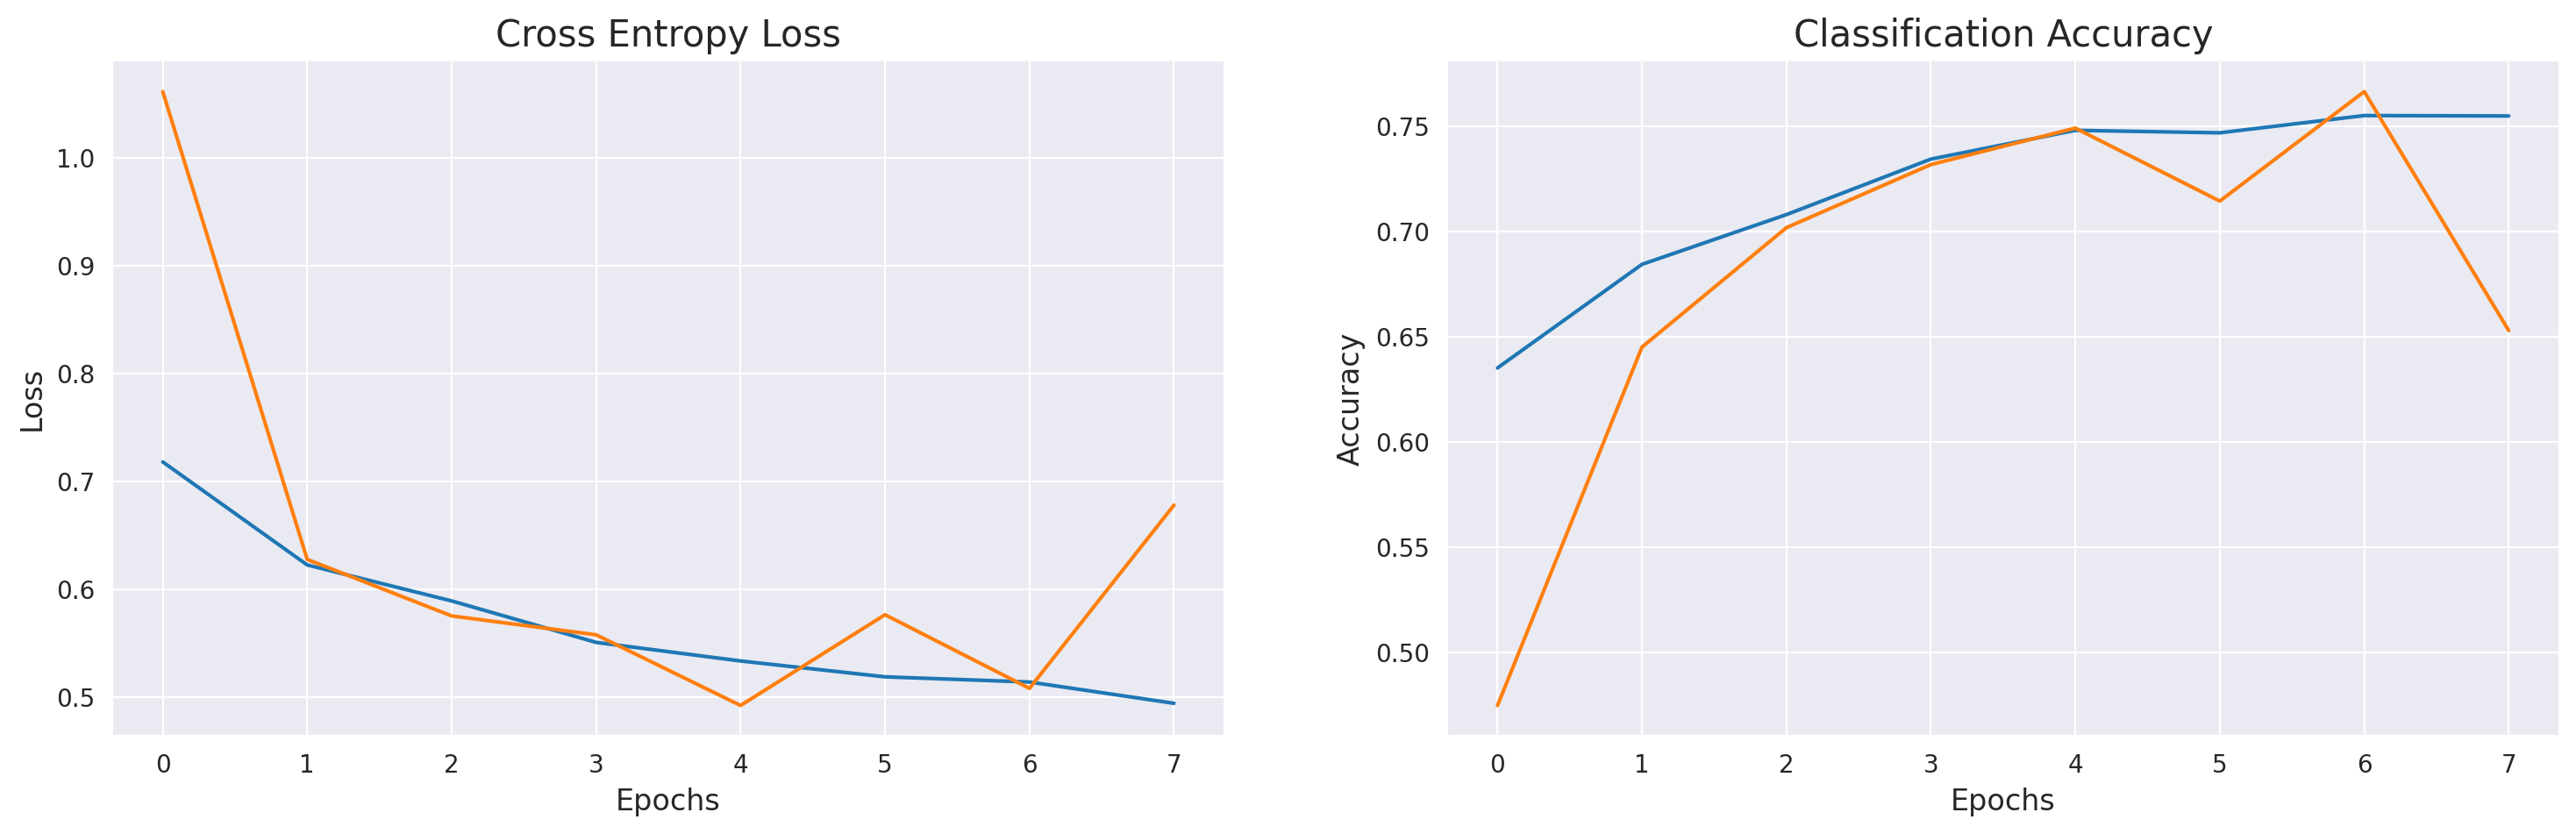

In [25]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

**Оценка**

Оценим точность и потерю данных обучения.

In [26]:


# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)



The accuracy of the model for training data is: 75.04884600639343
The Loss of the model for training data is: 0.5006744265556335
The accuracy of the model for validation data is: 74.92113709449768
The Loss of the model for validation data is: 0.49211403727531433


Наконец, мы сохраним модель для будущего использования.

In [ ]:
model.save("model.h5")

**Прогноз модель на тестовом наборе данных.**

In [ ]:
# prediction


result = model.predict(test_generator,batch_size = bat_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)


**Отчет по метрикам.**

In [77]:
labels =['no_george','george']
print(classification_report(y_true, y_pred,target_names=labels))


              precision    recall  f1-score   support

   no_george       0.75      0.80      0.77       335
      george       0.76      0.70      0.73       298

    accuracy                           0.75       633
   macro avg       0.75      0.75      0.75       633
weighted avg       0.75      0.75      0.75       633




Запуска модели, которая принимает на вход изображение и классифицирует на наличия или отсутствия святого Георгия.

Downloading...
From (original): https://drive.google.com/uc?id=1V_Hf5VnC42HU3aefx-WRMP1XPCeEuOhC
From (redirected): https://drive.google.com/uc?id=1V_Hf5VnC42HU3aefx-WRMP1XPCeEuOhC&confirm=t&uuid=ea806b4b-22b6-4636-b139-c06439e10833
To: /content/model.h5
100%|██████████| 313M/313M [00:03<00:00, 104MB/s] 


1/1 [==============================] - 0s 197ms/step
[[0.1003823  0.89961773]]
This is george


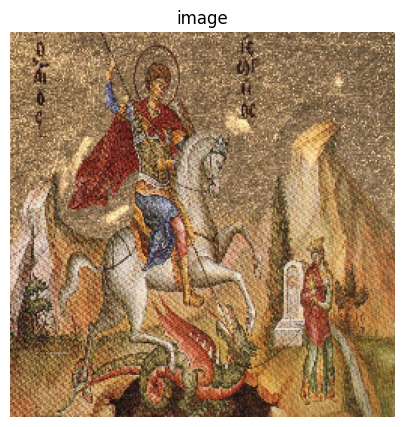

In [23]:
url = 'https://drive.google.com/file/d/1V_Hf5VnC42HU3aefx-WRMP1XPCeEuOhC/view?usp=drive_link'
output_path = 'model.h5'
gdown.download(url, output_path, quiet=False,fuzzy=True)

model.load_weights('model.h5')
image_path = "g.jpg" # path of the image
image = load_img(image_path, target_size=(256, 256))
img = np.array(image)
img = img / 255.0 # normalize the image
img = img.reshape(1, 256, 256, 3) # reshape for prediction
pred = model.predict(img)
print(pred)
if pred[0][1] > 0.5:
    label = 'george'
else:
    label = 'no_george'
print(f'This is {label}')

plt.figure(figsize=(5,5)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)
plt.imshow(image)
plt.title('image',fontsize=12)
plt.axis('off')
plt.show()